In [187]:
# data input libraries
import  numpy as np
import pandas as pd

In [188]:
# visualization library
import matplotlib.pyplot as plt

# style matplotlib as seaborn (modern)
from matplotlib import style
plt.style.use('seaborn-talk')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [189]:
# import data
df = pd.read_csv("../Phase1/main_data.csv", index_col=0)
df = df.dropna()
df

,# of bumps,# of inflections,curvature,min i,max i,x min,x max,y min,y max,S,criticality
0,3,0,3.255230,38,31,3.663562,3.465736,-11.639162,-10.540549,1.038058,1
1,0,0,1.404121,39,34,3.688879,3.555348,-11.066295,-10.373147,1.039465,1
2,0,0,-7.082191,6,0,1.945910,0.000000,-10.131818,-0.173747,1.063427,1
3,1,0,-8.379891,22,0,3.135494,0.000000,-10.842791,-0.665505,1.044607,1
4,1,0,-13.070105,36,36,3.610918,3.610918,-10.964433,-10.964433,1.041672,1
...,...,...,...,...,...,...,...,...,...,...,...
8793,0,0,-1.873302,59,63,5.823046,6.093570,-8.122181,-7.622121,1.077089,3
8794,0,0,-1.102228,53,65,5.472271,6.297109,-8.539737,-7.719609,1.077744,3
8795,1,0,-0.846527,67,71,7.021976,7.340836,-14.026634,-7.243576,1.106867,3
8796,0,0,-1.016451,66,67,6.200509,6.265301,-14.535209,-13.497222,1.073818,1


In [192]:
# configuting data set for training
from sklearn.model_selection import train_test_split

X = df.drop('criticality', axis=1).values
Y = df['criticality'].values - 1 # take the indices for the actual label: 0 = sub-critical, 1 = critical, 2 = super-critical

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(5747, 10)
(2464, 10)


# Pytorch

In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [194]:
# transforming data to tensor to use in pytorch
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

# number of features
n_f = x_tr.size()[1]
n_l = 3
n_f

10

In [195]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_f, 128)
        self.fc2 = nn.Linear(128, 30)
        self.fc3 = nn.Linear(30, n_l)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        output = F.softmax(x, dim=1)

        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


In [219]:
net = Net()    # recreate net anew
optimizer = optim.Adam(net.parameters(), lr=.01)
# optimizer = optim.SGD(net.parameters(), lr=.01)
# optimizer = optim.Adagrad(net.parameters(), lr=0.01, initial_accumulator_value=0.1)
criterion = nn.NLLLoss(weight=torch.tensor([1, 2.5, 1]))    # 2.5 weight of critical class

In [220]:
# this is the initial state of the network
(net.forward(x_ts).argmax(axis=1) + 1 ==y_ts).sum()/len(y_ts)

tensor(0.0828)

In [221]:
n_epoch=30
btch_size = 500

## Using dataloaders

In [222]:
## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)

In [223]:
test_dataset[0]

(tensor([  1.0000,   0.0000, -10.7648,  37.0000,  62.0000,   4.1897,   5.7526,
         -12.1356, -12.5951,   1.0982]),
 tensor(2))

## Mini-batch SGD optimization

In [224]:
for i, (X_batch, Y_batch) in enumerate(train_loader):
    print(Y_batch.size())
    break

torch.Size([500])


In [225]:
%%time
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss. 
sample_rate = 10
training_losses = []
test_losses = []

training_accuracy = []
test_accuracy = []

for i in range(n_epoch):
    print(f'Starting {i} epoch.')
    # print(len(training_losses))
    ind = 0

    for i, (X_batch, Y_batch) in enumerate(train_loader):
        # X_batch = X_batch.to(device)
        # Y_batch = Y_batch.to(device)
        ind += 1

        # Forward pass
        # #Precit the output for Given input
        outputs = net(X_batch)
        # print(outputs.type(), Y_batch.type())
        loss = criterion(outputs, Y_batch)

        # Backward and optimize
        #Clear the previous gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ## Every sample_rate, we record the loss and accuracy. 
        if ind%(int(n_s/btch_size/sample_rate))==0:
            y_tr_pred = net.forward(x_tr)
            training_losses += [F.nll_loss( y_tr_pred, y_tr).item() ]
            training_accuracy += [torch.sum( y_tr == 
                                          torch.argmax( y_tr_pred, axis=1 ) ).item()/n_s ]

            # print(F.nll_loss( net.forward(x_ts) , y_ts) )
            y_ts_pred = net.forward(x_ts)
            test_losses += [F.nll_loss( y_ts_pred, y_ts).item() ]
            test_accuracy += [torch.sum( y_ts == 
                                          torch.argmax( y_ts_pred, axis=1 )).item()/n_ts ]



Starting 0 epoch.
Starting 1 epoch.
Starting 2 epoch.
Starting 3 epoch.
Starting 4 epoch.
Starting 5 epoch.
Starting 6 epoch.
Starting 7 epoch.
Starting 8 epoch.
Starting 9 epoch.
Starting 10 epoch.
Starting 11 epoch.
Starting 12 epoch.
Starting 13 epoch.
Starting 14 epoch.
Starting 15 epoch.
Starting 16 epoch.
Starting 17 epoch.
Starting 18 epoch.
Starting 19 epoch.
Starting 20 epoch.
Starting 21 epoch.
Starting 22 epoch.
Starting 23 epoch.
Starting 24 epoch.
Starting 25 epoch.
Starting 26 epoch.
Starting 27 epoch.
Starting 28 epoch.
Starting 29 epoch.
CPU times: user 50.7 s, sys: 1.2 s, total: 51.9 s
Wall time: 13.4 s


In [226]:
print(training_accuracy)

[0.6838350443709762, 0.6970593353053767, 0.7360361927962416, 0.7489124760744736, 0.7513485296676526, 0.7541325909170001, 0.7607447363842005, 0.7741430311466853, 0.8105098312162867, 0.4216112754480599, 0.8286062293370454, 0.7962415173133809, 0.7852792761440752, 0.7807551766138855, 0.7783191230207065, 0.7804071689577171, 0.7837132416913172, 0.789107360361928, 0.7995475900469811, 0.8152079345745606, 0.8373064207412563, 0.8073777623107709, 0.8453105968331304, 0.844266573864625, 0.8308682791021402, 0.8232121106664346, 0.8240821298068558, 0.8279102140247085, 0.837828432225509, 0.8484426657386462, 0.8552288150339308, 0.8380024360535931, 0.852966765268836, 0.856272838002436, 0.8543587958935096, 0.8533147729250044, 0.8548808073777623, 0.8545327997215939, 0.8552288150339308, 0.8580128762832783, 0.8583608839394467, 0.8581868801113625, 0.8587088915956151, 0.8583608839394467, 0.8585348877675308, 0.8581868801113625, 0.8587088915956151, 0.8583608839394467, 0.857838872455194, 0.8555768226900992, 0.858

## Plot the results of SGD training

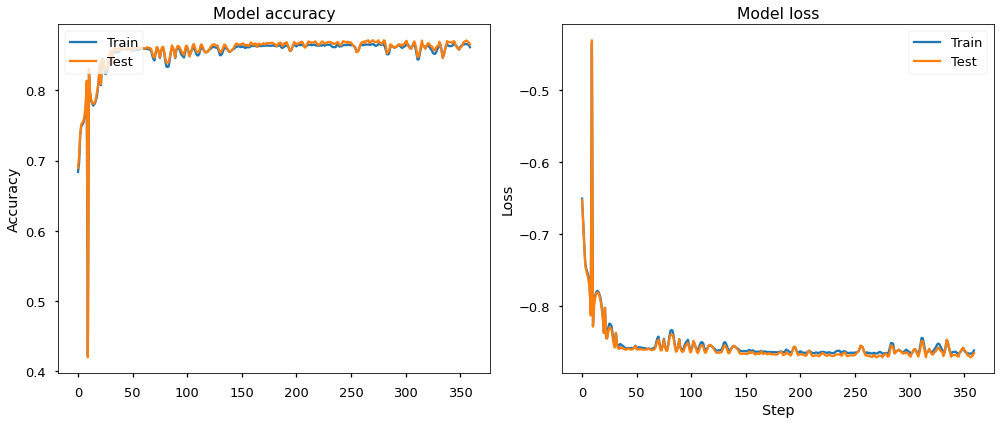

In [240]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.savefig("accuracy_loss_adam.jpg", dpi=150)
plt.show()

## Testing the final results with confusion matrix

In [233]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[[ 721    0   60]
 [ 108    0  123]
 [  41    0 1411]]


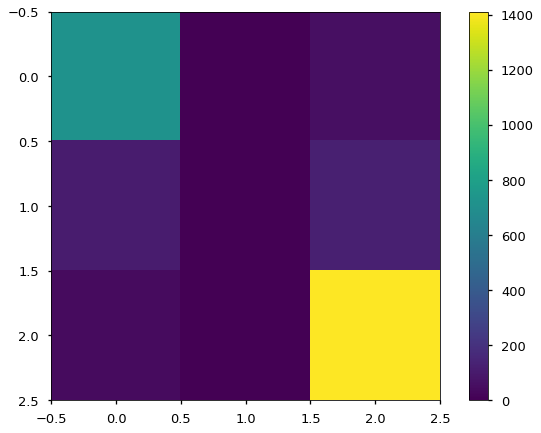

In [239]:
output = net.forward(x_ts)
matrix = confusion_matrix(y_ts, output.argmax(axis=1))
print(matrix)
plt.imshow(matrix)
plt.colorbar()
plt.savefig("confusion_matrix_adam.jpg", bbox_inches="tight", dpi=150)
plt.show()

Apparently we don't get any of the critical plots right. It's a big problem.

Might be because we don't have enough data for the critical region.